In [19]:
import sys
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from models import vgg8, vgg8_arcface, vgg8_cosface, vgg8_sphereface

In [20]:
with open('config.json') as f:
    config = json.load(f)

def load_data():
    (X, y), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

    y_test_orig = y_test.copy()

    X = X[:, :, :, np.newaxis].astype('float32') / 255
    X_test = X_test[:, :, :, np.newaxis].astype('float32') / 255

    y = tf.keras.utils.to_categorical(y, 10)
    y_test = tf.keras.utils.to_categorical(y_test, 10)

    return (X, y), (X_test, y_test), y_test_orig

In [21]:
(X, y), (X_test, y_test), y_test_orig = load_data()

In [5]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('model_arcface/',
                                                               verbose=1, 
                                                               save_best_only=True,
                                                               save_weights_only=False)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                           patience=30)

cosine_learing_rate_callback = CosineAnnealingScheduler(T_max=100,
                                                        eta_max=1e-2,
                                                        eta_min=1e-4,
                                                        verbose=1)
callbacks = [model_checkpoint_callback, early_stopping_callback, cosine_learing_rate_callback]

In [6]:
optimizer = tf.keras.optimizers.Adam(learning_rate=config["lr"])

model = vgg8_arcface(3)

model.compile(loss=config["loss"],
            optimizer=optimizer,
            metrics=config["metrics"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 28, 28, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 28, 28, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [7]:
model.fit([X, y], y, validation_data=([X_test, y_test], y_test),
        batch_size=config["batch_size"],
        epochs=100,
        callbacks=callbacks,
        verbose=1)

# model.fit(X, y, validation_data=(X_test, y_test),
#         batch_size=config["batch_size"],
#         epochs=100,
#         callbacks=callbacks,
#         verbose=1)

Epoch 1/100

Epoch 00001: CosineAnnealingScheduler setting learning rate to 0.01.
1875/1875 [==============================] - 72s 38ms/step - loss: 2.9191 - accuracy: 0.6927 - val_loss: 1.4544 - val_accuracy: 0.8519

Epoch 00001: val_loss improved from inf to 1.45437, saving model to model_arcface_big/
INFO:tensorflow:Assets written to: model_arcface_big/assets
Epoch 2/100

Epoch 00002: CosineAnnealingScheduler setting learning rate to 0.009997557473810372.
1875/1875 [==============================] - 69s 37ms/step - loss: 1.6347 - accuracy: 0.8465 - val_loss: 1.0087 - val_accuracy: 0.9520

Epoch 00002: val_loss improved from 1.45437 to 1.00866, saving model to model_arcface_big/
INFO:tensorflow:Assets written to: model_arcface_big/assets
Epoch 3/100

Epoch 00003: CosineAnnealingScheduler setting learning rate to 0.009990232305719944.
1875/1875 [==============================] - 68s 36ms/step - loss: 1.6429 - accuracy: 0.8694 - val_loss: 1.7786 - val_accuracy: 0.8896

Epoch 00003: val

KeyboardInterrupt: 

#### Plot embeddings

In [5]:
def plot_model_pred(model_name):
    face_model = tf.keras.models.load_model(f"model_{model_name}/")
    if model_name == 'softmax':
        face_model = tf.keras.Model(inputs=face_model.input, outputs=face_model.layers[-3].output)
    else:
        face_model = tf.keras.Model(inputs=face_model.input[0], outputs=face_model.layers[-3].output)
    face_features = face_model.predict(X_test, verbose=1)
    face_features /= np.linalg.norm(face_features, axis=1, keepdims=True)
    
    fig2 = plt.figure()
    ax2 = Axes3D(fig2)
    for c in range(len(np.unique(y_test_orig))):
        ax2.plot(face_features[y_test_orig==c, 0], face_features[y_test_orig==c, 1], face_features[y_test_orig==c, 2], '.', alpha=0.1)
    plt.title(f"{model_name[0].upper()}{model_name[1:]}")
    plt.show()

313/313 [==============================] - 3s 10ms/step


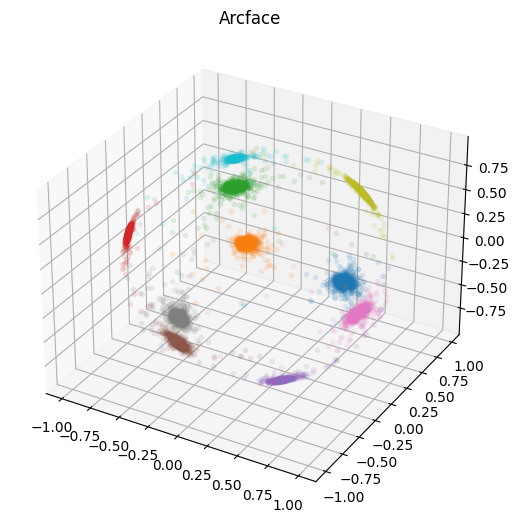

In [12]:
plot_model_pred('arcface')

313/313 [==============================] - 3s 11ms/step


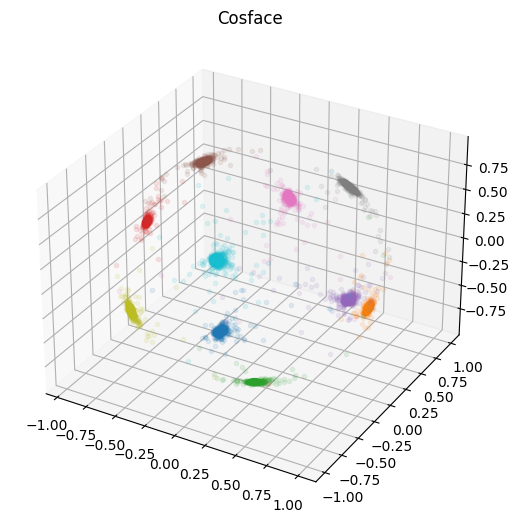

In [13]:
plot_model_pred('cosface')

313/313 [==============================] - 3s 11ms/step


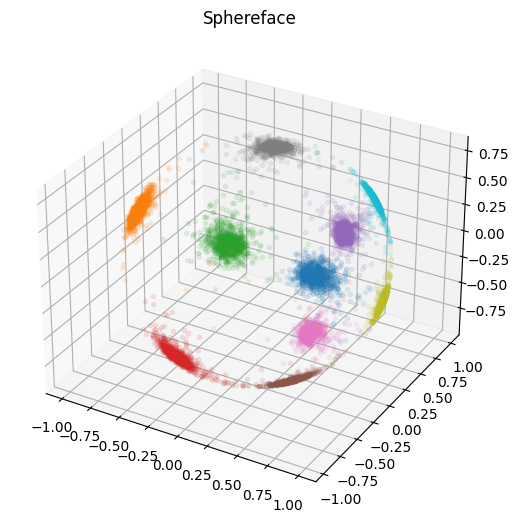

In [10]:
plot_model_pred('sphereface')

313/313 [==============================] - 5s 15ms/step


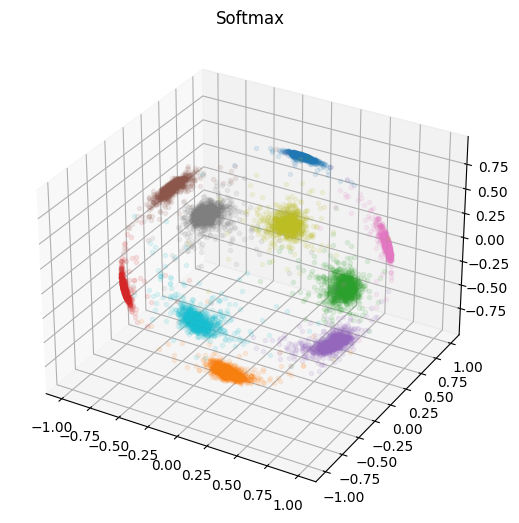

In [7]:
plot_model_pred('softmax')